# 一、数据介绍
来源https://tianchi.aliyun.com/dataset/148605  
2014年双12大促期间（2014-11-18至2014-12-18）提取的1万条用户行为数据  
user_id 用户标识   
item_id 商品标识   
behavior_type 用户对商品的行为类型 包括浏览、收藏、加购物车、购买，对应取值分别是1、2、3、4  
item_category 商品分类标识   
time 行为时间 精确到小时级别

In [2]:
#调用duckdb包使用sql分析数据，pandas和matplotlib进行可视化
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
df = pd.read_csv('D:\\user_action.csv')  
con = duckdb.connect()  

In [5]:
#简单查看数据结构
duckdb.sql("""
    select *
    from df
    limit 3
""").df()   

,user_id,item_id,behavior_type,item_category,time
0,98047837,232431562,1,4245,2014-12-06 02
1,97726136,383583590,1,5894,2014-12-09 20
2,98607707,64749712,1,2883,2014-12-18 11


In [2]:
duckdb.sql("""
    describe df
""")

┌───────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│  column_name  │ column_type │  null   │   key   │ default │  extra  │
│    varchar    │   varchar   │ varchar │ varchar │ varchar │ varchar │
├───────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ user_id       │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ item_id       │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ behavior_type │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ item_category │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ time          │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
└───────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [3]:
#把时间字符串转换为时间戳类型
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H')

In [29]:
conn = duckdb.connect() 

In [76]:
duckdb.sql("""
    describe df
""")

┌───────────────┬──────────────┬─────────┬─────────┬─────────┬─────────┐
│  column_name  │ column_type  │  null   │   key   │ default │  extra  │
│    varchar    │   varchar    │ varchar │ varchar │ varchar │ varchar │
├───────────────┼──────────────┼─────────┼─────────┼─────────┼─────────┤
│ user_id       │ BIGINT       │ YES     │ NULL    │ NULL    │ NULL    │
│ item_id       │ BIGINT       │ YES     │ NULL    │ NULL    │ NULL    │
│ behavior_type │ BIGINT       │ YES     │ NULL    │ NULL    │ NULL    │
│ item_category │ BIGINT       │ YES     │ NULL    │ NULL    │ NULL    │
│ time          │ TIMESTAMP_NS │ YES     │ NULL    │ NULL    │ NULL    │
└───────────────┴──────────────┴─────────┴─────────┴─────────┴─────────┘

In [7]:
#数据量
duckdb.sql("""
(select count(distinct user_id) AS "用户",
count(distinct item_id) AS "商品",
count(distinct item_category) AS "商品类目",
count(distinct behavior_type) AS "行为",
count(distinct time) AS "时间",
count(*) AS "数据量（条）" 
from df)
""")

┌───────┬─────────┬──────────┬───────┬───────┬──────────────┐
│ 用户  │  商品   │ 商品类目 │ 行为  │ 时间  │ 数据量（条） │
│ int64 │  int64  │  int64   │ int64 │ int64 │    int64     │
├───────┼─────────┼──────────┼───────┼───────┼──────────────┤
│ 10000 │ 2876947 │     8916 │     4 │   744 │     12256906 │
└───────┴─────────┴──────────┴───────┴───────┴──────────────┘

# 二、用户流量分析
访问量(PV)：Page View, 基于用户每次对淘宝页面的刷新次数，用户每刷新一次页面或者打开新的页面就记录就算一次访问。  
独立访问量(UV)：Unique Visitor，一个用户若多次访问淘宝只记录一次。

In [9]:
duckdb.sql("""
            select count(*) AS "PV",
                count(distinct user_id) AS "UV",
                count(*)/count(distinct user_id) AS "人均访问量"
                from df
                """).df()

,PV,UV,人均访问量
0,12256906,10000,1225.6906


In [62]:
duckdb.sql("""
            select max(time),min(time)
                from df
                """).df()

,"max(""time"")","min(""time"")"
0,2014-12-18 23:00:00,2014-11-18


## 1.基于小时的流量分析

In [65]:
hour_rate = duckdb.sql("""
                            select hour(time) AS hour,
                            count(user_id) AS PV,
                            count(distinct user_id) AS UV 
                            from df
                            group by 1
                            order by 1
                            """).df()
hour_rate

,hour,PV,UV
0,0,517404,5786
1,1,267682,3780
2,2,147090,2532
3,3,98516,1937
4,4,80487,1765
5,5,88296,2030
6,6,158798,3564
7,7,287337,5722
8,8,396106,7108
9,9,485951,7734


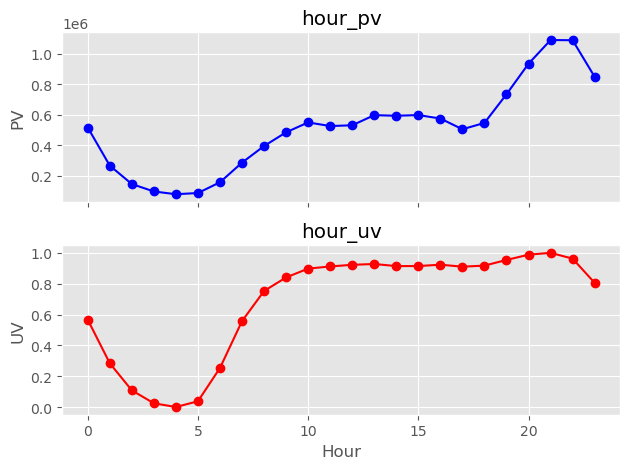

In [125]:
fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(hour_rate['hour'], hour_rate['PV'], marker='o', linestyle='-', color='blue')
axes[0].set_title('hour_pv')
axes[0].set_ylabel('PV')

hour_rate['UV_normalized'] = hour_rate['UV'].apply(lambda x: (x - hour_rate['UV'].min()) / (hour_rate['UV'].max() - hour_rate['UV'].min()))

axes[1].plot(hour_rate['hour'], hour_rate['UV_normalized'], marker='o', linestyle='-', color='red')
axes[1].set_title('hour_uv')
axes[1].set_ylabel('UV')

plt.xlabel('Hour')
plt.tight_layout()
plt.show()

图中可看出：  
1.uv和pv在5点到10点处于上升状态，uv在10点左右升到峰值，而pv升到一个稳定值。表明用户在晨间陆续访问淘宝，但单一用户的刷新次数并不高，可能只是随便看看而没有进入到选购状态  
2.uv和pv在10-17点都处于平稳状态  
3.uv和pv在17点之后有上升趋势，uv上升幅度小，pv大幅上升，21点达到峰值。表明用户在这个时间段反复刷新淘宝界面，充分进入选购状态。  
4.uv和pv的数值在0点到5点之间处于一个快速下降的阶段，到5点跌到谷底，这符合大多数人群的睡眠规律，即到12点后开始渐渐入睡。

## 2.基于天的流量分析

In [155]:
day_rate = duckdb.sql("""
                            select strftime(time,'%m-%d') AS day,
                            count(user_id) AS PV,
                            count(distinct user_id) AS UV 
                            from df
                            group by 1
                            order by 1
                            """).df()
day_rate

,day,PV,UV
0,11-18,366701,6343
1,11-19,358823,6420
2,11-20,353429,6333
3,11-21,333104,6276
4,11-22,361355,6187
5,11-23,382702,6373
6,11-24,378342,6513
7,11-25,370239,6351
8,11-26,360896,6357
9,11-27,371384,6359


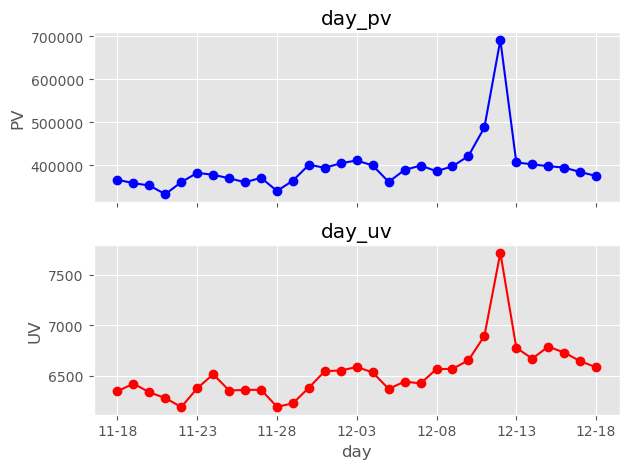

In [159]:
import matplotlib.ticker as ticker
fig, axes = plt.subplots(2, 1, sharex=True)
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(5))

axes[0].plot(day_rate['day'], day_rate['PV'], marker='o', linestyle='-', color='blue')
axes[0].set_title('day_pv')
axes[0].set_ylabel('PV')

axes[1].plot(day_rate['day'], day_rate['UV'], marker='o', linestyle='-', color='red')
axes[1].set_title('day_uv')
axes[1].set_ylabel('UV')

plt.xlabel('day')
plt.tight_layout()
plt.show()

双十二大促窗口期间用户访问显著提升

# 三、用户分层
RFM模型是衡量客户价值和客户创利能力的重要工具和手段，其中由3个要素构成了数据分析的指标，分别是：

R-Recency（最近一次购买时间）

F-Frequency（消费频率）

M-Money（消费金额）

由于数据源没有相关的金额数据，暂且通过R和F的数据对客户进行分层。

为避免大促短期活动的扰乱，用户分层避开大促时间窗口12.10-12.18：从日流量走势来看12.10开始大幅上升，促销期间的加购可能在活动结束后成交，将窗口延长至12.18.

In [4]:
#R最近一次购买时间及排序
r_number=duckdb.sql("""
select 
*,
row_number() over (order by a.recency desc) as r_number
from
     (
     select 
     user_id,
     datediff('day',TIMESTAMP'2014-12-09 23:00:00',CAST(MAX(time) AS TIMESTAMP)) as recency
     from df
     where behavior_type=4 and time<'2014-12-10'
     group by user_id
                        ) a
                        """).df()
r_number

,user_id,recency,r_number
0,104811265,0,1
1,124546232,0,2
2,121006999,0,3
3,25871996,0,4
4,99792011,0,5
...,...,...,...
8079,134928476,-21,8080
8080,62546002,-21,8081
8081,93422967,-21,8082
8082,79614874,-21,8083


In [88]:
con = duckdb.connect()

In [5]:
#F购买频率及排序
f_number=duckdb.sql("""
select 
*,
row_number()over(order by a.frequency desc) as f_number
from
    (select 
    user_id,
    count(*) as frequency
    from df
    where behavior_type=4 and time<'2014-12-10'
    group by user_id
     ) a
                """).df()
f_number

,user_id,frequency,f_number
0,122338823,598,1
1,123842164,467,2
2,51492142,281,3
3,35306096,168,4
4,33448326,143,5
...,...,...,...
8079,92999201,1,8080
8080,60457466,1,8081
8081,54707710,1,8082
8082,118372628,1,8083


In [92]:
con = duckdb.connect()

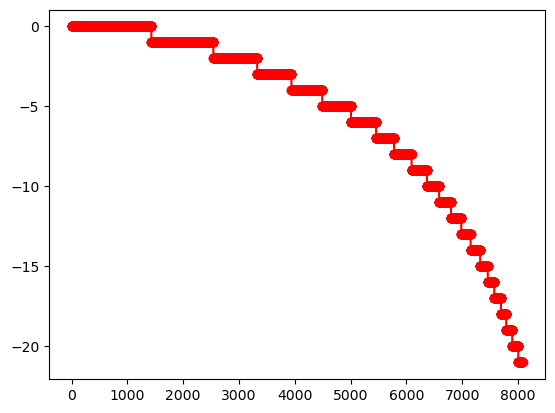

In [144]:
plt.plot(r_number['recency'], marker='o', linestyle='-', color='red')

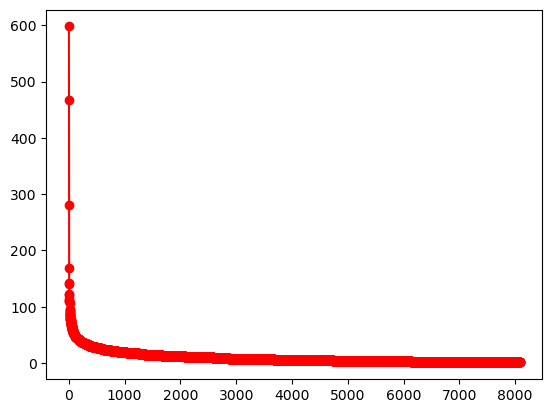

In [145]:
plt.plot(f_number['frequency'], marker='o', linestyle='-', color='red')

从分布来看，
对于最近一次消费时间，大概50%的用户最近一次消费时间较近（0-5天的间隔），50%的用户最近一次消费时间较远 （5天以上） 
对于消费频率，20%的用户消费频率较高，80%的用户消费频率较低  
基于此按照R和F对用户进行分层：  
最近一次消费时间排序前50% & 消费频率排序前20%——重要价值用户，   
最近一次消费时间排序前50% & 消费频率排序后80%——重要发展用户，意味着可能是新客，注重提升用户的使用频率  
最近一次消费时间排序后50% & 消费频率排序前20%——重要保持用户，最近活跃度低但是稳定购买的用户  
最近一次消费时间排序后50% & 消费频率排序后80%——重要挽留用户，易流失，需要挽留的用户 

In [6]:
user_class=duckdb.sql("""
select *,
(case 
when r_number <=8886*0.5 and f_number <=8886*0.2 then '重要价值用户'
when r_number <=8886*0.5 and f_number >8886*0.2 then '重要发展用户'
when r_number >8886*0.5 and f_number <=8886*0.2 then '重要保持用户'
when r_number >8886*0.5 and f_number >8886*0.2 then '重要挽留用户' end) as user_class
from r_number r
join f_number f using(user_id)
""").df()
user_class

,user_id,recency,r_number,frequency,f_number,user_class
0,104811265,0,1,8,2945,重要发展用户
1,124546232,0,2,5,4397,重要发展用户
2,121006999,0,3,9,2651,重要发展用户
3,25871996,0,4,25,585,重要价值用户
4,99792011,0,5,13,1694,重要价值用户
...,...,...,...,...,...,...
8079,134928476,-21,8080,7,3525,重要挽留用户
8080,62546002,-21,8081,1,7770,重要挽留用户
8081,93422967,-21,8082,1,7716,重要挽留用户
8082,79614874,-21,8083,1,7686,重要挽留用户


In [98]:
con = duckdb.connect()

In [7]:
user_action_class=duckdb.sql("""
select *,
from df
left join user_class using(user_id)
""").df()
user_action_class

,user_id,item_id,behavior_type,item_category,time,recency,r_number,frequency,f_number,user_class
0,86239261,269216169,1,7393,2014-11-29 15:00:00,-1,2394,35,283,重要价值用户
1,7391440,7524639,1,1838,2014-11-28 20:00:00,-2,2587,12,1880,重要发展用户
2,40310645,172753432,1,10481,2014-12-15 02:00:00,-2,3119,5,4673,重要发展用户
3,117801453,82632228,1,3833,2014-11-23 20:00:00,-1,2519,18,1112,重要价值用户
4,3543407,321392764,1,1083,2014-11-20 17:00:00,-14,7163,4,4892,重要挽留用户
...,...,...,...,...,...,...,...,...,...,...
12256901,65544144,249685244,1,1863,2014-12-11 19:00:00,<NA>,<NA>,<NA>,<NA>,None
12256902,65544144,327639891,1,3381,2014-12-04 08:00:00,<NA>,<NA>,<NA>,<NA>,None
12256903,65544144,128186279,1,3381,2014-12-04 08:00:00,<NA>,<NA>,<NA>,<NA>,None
12256904,65544144,188445293,1,3381,2014-12-04 08:00:00,<NA>,<NA>,<NA>,<NA>,None


In [119]:
con = duckdb.connect()

In [149]:
 duckdb.sql("""
select user_class,count(distinct user_id) 
from user_action_class
group by user_class
""").df()

,user_class,count(DISTINCT user_id)
0,None,1916
1,重要保持用户,347
2,重要挽留用户,3294
3,重要价值用户,1430
4,重要发展用户,3013


可以看出人群主要被重要发展客户和重要挽留客户占据，所以接下来的任务是提高重要发展用户的购买频率，提高他们的购买欲望，并且提高他们的购物车和收藏的转化率；对于user_class=none的用户（意味着他们从未有过购买行为）以及重要挽留用户，可以用各种方式刺激他们的消费和对应用的浏览量，增加对这一部分用户的互动，比如推荐在他们购物车或者收藏中的同类商品。

# 四、转化率分析（大促前）
-全体用户各环节转化率分析  
-分层用户各环节转化率分析

## 1.各环节转化率

In [8]:
#创建新表
new=duckdb.sql("""
select user_id,item_id,user_class,item_category,
        count(case when behavior_type = 1 then 1 end) AS pv,
        count(case when behavior_type=2 or behavior_type=3  then 1 end) AS favcart,
        count(case when behavior_type = 4 then 1 end) AS buy
from user_action_class
where time<'2014-12-10'
group by 1,2,3,4
""").df()
new

,user_id,item_id,user_class,item_category,pv,favcart,buy
0,86239261,144655310,重要价值用户,7393,2,0,0
1,117801453,358975132,重要价值用户,9179,4,0,0
2,86239261,5507548,重要价值用户,6512,2,0,0
3,141016162,253833588,重要挽留用户,7957,3,0,0
4,38839327,353141779,重要价值用户,5232,2,0,0
...,...,...,...,...,...,...,...
3239837,107113176,74690882,重要发展用户,292,1,0,0
3239838,17384431,328601139,None,10523,1,0,0
3239839,30511142,66035497,重要挽留用户,11757,1,0,0
3239840,124832591,282073881,重要挽留用户,13230,1,0,0


In [151]:
#整体用户转化率
duckdb.sql("""
select sum(pv) AS total_pv,
    sum(favcart) AS total_favcart,
    round(sum(favcart)/sum(pv),2) as pv_to_favcart,
    sum(buy) AS total_buy,
    round(sum(buy)/sum(favcart),2) as favcart_to_buy
from new
""").df()

,total_pv,total_favcart,pv_to_favcart,total_buy,favcart_to_buy
0,7816504.0,397927.0,0.05,76815.0,0.19


In [152]:
#分层用户转化率
duckdb.sql("""
select sum(pv) AS total_pv,
    sum(favcart) AS total_favcart,
    round(sum(favcart)/sum(pv),2) as pv_to_favcart,
    sum(buy) AS total_buy,
    round(sum(buy)/sum(favcart),2) as favcart_to_buy,
    user_class
from new
group by user_class
order by favcart_to_buy desc
""").df()

,total_pv,total_favcart,pv_to_favcart,total_buy,favcart_to_buy,user_class
0,2485459.0,154953.0,0.06,38335.0,0.25,重要价值用户
1,479847.0,31275.0,0.07,7433.0,0.24,重要保持用户
2,2279988.0,99285.0,0.04,18255.0,0.18,重要发展用户
3,2010672.0,87647.0,0.04,12792.0,0.15,重要挽留用户
4,560538.0,24767.0,0.04,0.0,0.00,None


* 对于重要保持用户，可以看出从浏览到加购的转化率（0.07）相对其他用户群较高，而从加购到购买的转化（0.24）则略微低于重要价值用户，此类用户对商品展现出兴趣，有“逛街”和“收藏”的网上购物习惯，但实现购买的动力相对重要价值用户不足。可侧重在对其加购商品的曝光策略和销售策略。   
* 对于重要发展用户和重要挽留用户，浏览-加购 以及 加购-购买 的转化率都低于整体的转化率。策略需要同时往两个方向侧重。

## 2.不同行为链路转化率 

In [153]:
#直接购买的转化率
duckdb.sql("""
select 
sum(pv) AS 点击数,
sum(buy) AS 购买,
round(sum(buy)/sum(pv),4) AS 转化率 
from new 
where favcart = 0
""").df()

,点击数,购买,转化率
0,6218145.0,26184.0,0.0042


In [154]:
duckdb.sql("""
select 
sum(pv) AS 点击数,
sum(buy) AS 购买,
round(sum(buy)/sum(pv),4) AS 转化率 ,
user_class
from new 
where favcart = 0
group by user_class
order by 转化率 desc
""").df()

,点击数,购买,转化率,user_class
0,1857022.0,10316.0,0.0056,重要价值用户
1,360318.0,1912.0,0.0053,重要保持用户
2,1861086.0,8239.0,0.0044,重要发展用户
3,1657552.0,5717.0,0.0034,重要挽留用户
4,482167.0,0.0,0.0000,None


In [155]:
#经过收藏&加购的购买转化率
duckdb.sql("""
select 
sum(pv) AS 点击数,
sum(buy) AS 购买,
round(sum(buy)/sum(pv),4) AS 转化率 
from new 
where favcart > 0
""").df()

,点击数,购买,转化率
0,1598359.0,50631.0,0.0317


In [156]:
duckdb.sql("""
select 
sum(pv) AS 点击数,
sum(buy) AS 购买,
round(sum(buy)/sum(pv),4) AS 转化率 ,
user_class
from new 
where favcart > 0
group by user_class
order by 转化率 desc
""").df()

,点击数,购买,转化率,user_class
0,119529.0,5521.0,0.0462,重要保持用户
1,628437.0,28019.0,0.0446,重要价值用户
2,418902.0,10016.0,0.0239,重要发展用户
3,353120.0,7075.0,0.0200,重要挽留用户
4,78371.0,0.0,0.0000,None


1.  

* **经过收藏&加购来达成购买**的转化率和购买量都大大高于**直接购买**，这说明**加购&收藏**的功能可以有效促进用户转化。产品界面可以持续突出**收藏&加购**功能。

* 一方面**收藏&加购**功能让用户在浏览商品时可以存下自己心仪的商品，给了用户可以不带购买目的、在网上“逛街”、对商品表心意并方便之后购买的条件，因此淘宝不单是仅满足购物需求的APP，也可以服务于用户娱乐消遣的需求。培养起用户的这种使用习惯可以提升用户的访问、活跃和留存。  
购物车让用户方便有对商品重复访问、停留、货比三家的动作，符合用户的购物心理和习惯。因此大部分商品通过购物车转化。

2.  
* 从分层用户来看，重要价值和重要保持用户，**经过收藏&加购的购买量**（28019，5521）比**直接购买量**（10316，1912）增加了**1倍以上**，而重要发展用户和重要挽留用户只增加了**不到1倍**。说明这两类客户的消费频率较低、转化率较低的情况，可能与他们**收藏&加购这一使用习惯相对不牢固**有关。因此，策略可重点考虑对这类用户根据算法持续推荐曝光相关商品和趣味、高质量商品，增加用户对APP提供的商品的兴趣，培养出对兴趣商品收藏加购的使用习惯。  

* 另外，这两类用户经过**收藏&加购**的购买转化率也比其他两类低一倍左右，因此同时也要提升对加购商品的购买转化。可考虑对加购商品进行限时折扣和捆绑销售。

In [157]:
#量化“收藏&加购习惯不牢固” 
#收藏&加购占比 = （用户收藏+加购行为数） / 总行为数 
#分层用户群体间对比该指标，验证假设是否成立（重要发展&挽留用户是否显著低于其他用户）。
duckdb.sql("""
select 
sum(favcart) as 收藏加购数,
sum(pv)+sum(favcart)+sum(buy) as 总行为数,
round(sum(favcart)/(sum(pv)+sum(favcart)+sum(buy)),2) as 占比,
user_class
from new 
group by user_class
order by 占比 desc
""").df()

,收藏加购数,总行为数,占比,user_class
0,31275.0,518555.0,0.06,重要保持用户
1,154953.0,2678747.0,0.06,重要价值用户
2,99285.0,2397528.0,0.04,重要发展用户
3,87647.0,2111111.0,0.04,重要挽留用户
4,24767.0,585305.0,0.04,None


重要发展用户&重要挽留用户的收藏加购行为占比确实低于重要保持用户&重要价值用户，“收藏加购习惯不牢固”的假设成立。

# 五、转化率优化分析 
基于上一部分的分析，进一步对“点击-收藏&加购”“收藏&加购-购买”两个转化环节进行分析

## 1.点击-加购
这一环节的转化率低可能是什么原因，如何提升点击-加购的转化率，从而更大化通过加购带来的购买转化率效益  
全体用户的点击-加购转化都很低，因此不进行用户分层分析

### 点击质量分析    

In [158]:
#无效点击的比例：仅有1次浏览（点击）无重复点击也无后续动作/所有点击的比例 
duckdb.sql("""
select 
count(case when pv=1 and favcart=0 and buy=0 then 1 end) as 无效点击数,
count(case when pv=1 and favcart=0 and buy=0 then 1 end)/count(*) as 占比
from new 
""").df()

,无效点击数,占比
0,920198,0.284026


无效点击占比在28.5%左右，不算异常值水平，但也可以考虑进一步优化推荐算法，实现更精准的推荐和更有效的点击，以及优化商品曝光质量，比如检查商品页面的加载速度、布局设计、产品描述和图片质量等因素，使用A/B测试等方法，尝试不同的广告文案和视觉效果，找出最有效的组合。

In [159]:
#识别无效点击数占比较大的商品类别
ineffective=duckdb.sql("""
select 
item_category,
count(case when pv=1 and favcart=0 and buy=0 then 1 end) as 无效点击数,
count(*) as 类目点击总数,
count(case when pv=1 and favcart=0 and buy=0 then 1 end)/count(*) as 占比
from new
group by item_category
order by 3 desc
""").df()
ineffective

,item_category,无效点击数,类目点击总数,占比
0,1863,29156,102449,0.284590
1,13230,27125,97455,0.278334
2,5894,27679,93655,0.295542
3,5027,21790,80549,0.270519
4,6513,22994,80198,0.286715
...,...,...,...,...
8495,12051,0,1,0.000000
8496,975,0,1,0.000000
8497,13204,0,1,0.000000
8498,884,0,1,0.000000


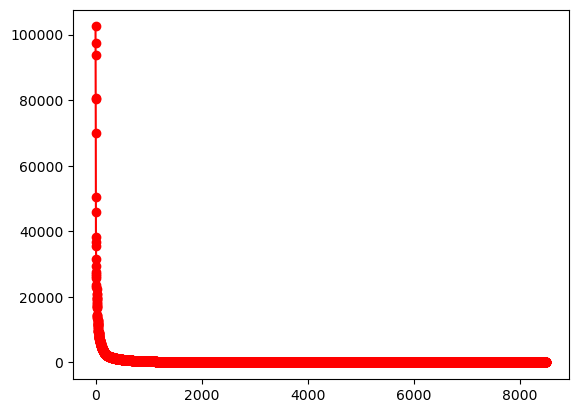

In [160]:
#查看商品类目的点击量分布
plt.plot(ineffective['类目点击总数'], marker='o', linestyle='-', color='red')

In [161]:
#重点关注 点击总数高&无效点击比例较大 的商品类目
duckdb.sql("""
select *
from ineffective
where 类目点击总数>10000 and 占比>0.285
order by 类目点击总数 desc
""").df()

,item_category,无效点击数,类目点击总数,占比
0,5894,27679,93655,0.295542
1,6513,22994,80198,0.286715
2,11279,15232,50604,0.301004
3,2825,13395,46030,0.291006
4,10894,11121,38127,0.291683
5,5689,9113,31509,0.289219
6,14079,7958,27657,0.287739
7,5395,8505,26244,0.324074
8,10392,8396,25803,0.325389
9,9516,6680,22882,0.291933


找出了50个可被优化无效点击的商品类目，若有具体的类目特点数据还可继续聚类分析

## 2.加购-购买
这一环节的转化率低可能是什么原因，如何提升重要发展用户和重要挽留用户的加购-购买转化率  
对重要发展用户和重要挽留用户进行分析

### 收藏&加购-购买的决策时间差分析 

In [165]:
#max()找出最近一次加购和最近一次购买，计算时间差
#having筛掉无效数据（无购买，无收藏&加购，最新加购还未购买的记录）
new2=duckdb.sql("""
select
        user_id,
        item_id,
        user_class,
        item_category,
        count(case when behavior_type = 1 then 1 end) AS pv,
        count(case when behavior_type=2 or behavior_type=3  then 1 end) AS favcart,
        count(case when behavior_type = 4 then 1 end) AS buy,
        max(case when behavior_type = 4 then time end) as last_purchase_time,
        max(case when behavior_type in (2,3) then time end) as last_favcart_time,
        datediff('day',
                cast(max(case when behavior_type in (2,3) then time end) as timestamp),
                cast(max(case when behavior_type = 4 then time end)as timestamp)
                ) as gap
    from user_action_class
    where time<'2014-12-10'
    group by user_id,item_id,user_class,item_category
    having last_purchase_time is not null and last_favcart_time is not null and last_favcart_time<=last_purchase_time
    order by gap desc
    """).df()
new2

,user_id,item_id,user_class,item_category,pv,favcart,buy,last_purchase_time,last_favcart_time,gap
0,55252215,13567153,重要发展用户,3660,16,1,1,2014-12-09 20:00:00,2014-11-19 08:00:00,20
1,79359253,297385908,重要发展用户,6744,11,1,1,2014-12-08 20:00:00,2014-11-18 22:00:00,20
2,36513563,303658735,重要价值用户,11508,14,1,1,2014-12-09 21:00:00,2014-11-19 15:00:00,20
3,35389479,269198641,重要价值用户,7467,12,1,1,2014-12-07 11:00:00,2014-11-18 10:00:00,19
4,120560904,238017630,重要发展用户,5232,14,1,2,2014-12-07 15:00:00,2014-11-18 18:00:00,19
...,...,...,...,...,...,...,...,...,...,...
39113,131538712,74262391,重要价值用户,6513,7,3,1,2014-12-03 17:00:00,2014-12-03 17:00:00,0
39114,29020561,322957624,重要挽留用户,13500,5,2,2,2014-12-03 16:00:00,2014-12-03 16:00:00,0
39115,13103318,278208180,重要价值用户,4560,2,2,1,2014-12-02 23:00:00,2014-12-02 23:00:00,0
39116,123562447,403909671,重要保持用户,11599,3,1,1,2014-11-20 16:00:00,2014-11-20 16:00:00,0


In [166]:
#分层用户看平均决策时间差差异
duckdb.sql("""
select
user_class,
round(avg(gap),2) as gap_avg
from new2
where last_purchase_time is not null and last_favcart_time is not null and last_favcart_time<=last_purchase_time
group by user_class
order by gap_avg
""").df()

,user_class,gap_avg
0,重要保持用户,0.17
1,重要价值用户,0.19
2,重要挽留用户,0.26
3,重要发展用户,0.39


* 重要发展&重要挽留用户比重要价值&重要保持用户的收藏&加购-购买平均时间差更长  
* 采用策略缩短收藏&加购-购买的时间差也许能够提升收藏&加购-购买转化率  
* 比如可对重要发展&重要挽留用户设置加购商品限时折扣（如24小时内下单享额外优惠），提升紧迫感

### 高购买商品类目&高弃购商品类目分析  

In [168]:
#高收藏&加购但高弃购类目
duckdb.sql("""
select
item_category,
sum(favcart) as total_favcart,
sum(buy) as total_buy
from new
where user_class in ('重要发展用户','重要挽留用户') 
group by item_category
having total_favcart>0 and total_buy=0 
order by total_favcart desc
limit 10
""").df()

,item_category,total_favcart,total_buy
0,7383,181.0,0.0
1,10582,83.0,0.0
2,384,67.0,0.0
3,9942,58.0,0.0
4,3892,44.0,0.0
5,2739,39.0,0.0
6,7140,37.0,0.0
7,9401,37.0,0.0
8,6588,37.0,0.0
9,8966,36.0,0.0


In [126]:
#高购买类目
duckdb.sql("""
select
item_category,
sum(favcart) as total_favcart,
sum(buy) as total_buy,
from new
where user_class in ('重要发展用户','重要挽留用户') 
group by item_category
having total_favcart>0 
order by total_buy desc
limit 10
""").df()

,item_category,total_favcart,total_buy
0,1863,11222.0,970.0
1,6344,2544.0,840.0
2,5232,3785.0,769.0
3,3424,1424.0,696.0
4,5399,6354.0,492.0
5,6513,6907.0,482.0
6,8877,1536.0,470.0
7,1838,1373.0,458.0
8,3472,1076.0,449.0
9,5027,7221.0,444.0


加大对高购买类目的推荐曝光，对高弃购商品类目找出弃购原因进行优化

# 六、大促效果衡量
### 大促前和大促期间的转化效果对比

In [170]:
before=duckdb.sql("""
select user_id,item_id,user_class,item_category,
        count(case when behavior_type = 1 then 1 end) AS pv,
        count(case when behavior_type=2 or behavior_type=3  then 1 end) AS favcart,
        count(case when behavior_type = 4 then 1 end) AS buy
from user_action_class
where time < '2014-12-10'
group by 1,2,3,4
""").df()


undergoing=duckdb.sql("""
select user_id,item_id,user_class,item_category,
        count(case when behavior_type = 1 then 1 end) AS pv,
        count(case when behavior_type=2 or behavior_type=3  then 1 end) AS favcart,
        count(case when behavior_type = 4 then 1 end) AS buy
from user_action_class
where time >= '2014-12-10'
group by 1,2,3,4
""").df()

#整体转化对比
duckdb.sql("""
select 
    '非大促期间' as timing,
    sum(pv) AS total_pv,
    sum(favcart) AS total_favcart,
    round(sum(favcart)/sum(pv),2) as pv_to_favcart,
    sum(buy) AS total_buy,
    round(sum(buy)/sum(favcart),2) as favcart_to_buy
from before
union
select 
     '大促期间' as timing,
    sum(pv) AS total_pv,
    sum(favcart) AS total_favcart,
    round(sum(favcart)/sum(pv),2) as pv_to_favcart,
    sum(buy) AS total_buy,
    round(sum(buy)/sum(favcart),2) as favcart_to_buy
from undergoing
""").df()

,timing,total_pv,total_favcart,pv_to_favcart,total_buy,favcart_to_buy
0,大促期间,3734077.0,188193.0,0.05,43390.0,0.23
1,非大促期间,7816504.0,397927.0,0.05,76815.0,0.19


In [199]:
#分层用户转化率对比
compare=duckdb.sql("""
select 
    user_class,
    '非大促期间' as timing,
    sum(pv) AS total_pv,
    sum(favcart) AS total_favcart,
    round(sum(favcart)/sum(pv),2) as pv_to_favcart,
    sum(buy) AS total_buy,
    round(sum(buy)/sum(favcart),2) as favcart_to_buy
from before
group by user_class
union
select 
    user_class,
    '大促期间' as timing,
    sum(pv) AS total_pv,
    sum(favcart) AS total_favcart,
    round(sum(favcart)/sum(pv),2) as pv_to_favcart,
    sum(buy) AS total_buy,
    round(sum(buy)/sum(favcart),2) as favcart_to_buy
from undergoing
group by user_class
order by user_class, timing
""").df()
con = duckdb.connect()

compare['user_class'] = compare['user_class'].fillna('无购买用户')

compare

,user_class,timing,total_pv,total_favcart,pv_to_favcart,total_buy,favcart_to_buy
0,重要价值用户,大促期间,1036909.0,62277.0,0.06,16043.0,0.26
1,重要价值用户,非大促期间,2485459.0,154953.0,0.06,38335.0,0.25
2,重要保持用户,大促期间,196869.0,11811.0,0.06,2484.0,0.21
3,重要保持用户,非大促期间,479847.0,31275.0,0.07,7433.0,0.24
4,重要发展用户,大促期间,1141957.0,51161.0,0.04,12196.0,0.24
5,重要发展用户,非大促期间,2279988.0,99285.0,0.04,18255.0,0.18
6,重要挽留用户,大促期间,977779.0,45872.0,0.05,9824.0,0.21
7,重要挽留用户,非大促期间,2010672.0,87647.0,0.04,12792.0,0.15
8,无购买用户,大促期间,380563.0,17072.0,0.04,2843.0,0.17
9,无购买用户,非大促期间,560538.0,24767.0,0.04,0.0,0.00


重要发展&重要挽留&无购买用户的收藏&加购-购买转化率明显提升，说明大促的折扣、满减、限时等策略有有效的促活、冷启作用

# 七、整体结论和建议
结合流量特征、用户行为和转化特征、大促效果，提供淘宝的优化建议

## 流量时段精细化运营

1. 晨间时段（5:00-10:00）
* UV与PV逐步上升，用户开始活跃但访问频次不高。用户多为“随意浏览”而非目标购物。

* 可能的策略：通过系统推送早餐、日化、通勤用品等高频刚需类目，结合轻量级营销活动（如“晨间秒杀”），吸引用户下单。利用AI算法识别用户近期浏览的“快速决策型商品”（如纸巾、零食），强化首页曝光及限时优惠提示。

2. 午间时段（10:00-17:00）
* UV与PV保持稳定，用户碎片化访问。
* 可能的策略：针对办公时段用户碎片化浏览特点，推荐短时种草内容（短视频、图文评测），并设置“午间逛逛”休闲专区，增强用户停留时长。

3. 晚间时段（17:00-24:00）
* PV增速显著高于UV，用户深度浏览和比价行为集中。为全天核心成交窗口。
* 可能的策略：打造沉浸式购物场景聚合流量：启动“夜淘”主题活动，聚集高折扣商品、直播专场（如服饰试穿、美妆教程）。对加购超过24小时的商品自动发放“夜间专属券”（如满200减20），刺激即时成交。



## 用户分层精准运营

1. 高潜力用户（重要发展用户&重要挽留用户）
* 收藏加购习惯不足，且加购后转化周期长。大促期间转化率显著提升，但对常规促销敏感度低。
* 可能的策略：通过兴趣商品精准推荐曝光、任务体系（如“连续加购3天领红包”）、页面设计（提示“同类加购商品降价X元”），强化收藏/加购行为；对加购商品投放“倒计时优惠”，并通过推送提醒，缩短决策周期。

2. 无购买用户（None类用户）
* 无历史订单,但大促活动期间存在转化。
* 冷启动策略：体验式转化，开放如“新客试用”专区，降低首单决策门槛；推荐高性价比小件商品（如9.9包邮）。兴趣挖掘，利用大数据补充用户画像，定向推送兴趣类目。通过大促活动有效冷启。

3. 高价值用户（重要保持用户&重要价值用户）
* 转化较高，购买频率较高.
* 忠诚度提升：开放专属权益，如开放VIP客服通道；交叉销售，基于历史订单匹配关联商品（如购买奶粉后推荐辅食机），提升LTV（用户生命周期价值）。




## 转化路径效率提升

1. 无效点击治理
* 针对识别出的低效点击类目，根据具体类目情况制定策略，比如优化广告和详情页设计，或动态降低低效类目曝光权重。
* 优化推荐算法，对用户精准推荐感兴趣、高历史购买、高转化类目。

2. 收藏加购场景优化
* 在商品详情页增加“加购后推荐相似款”模块，利用对比决策提升转化。购物车页可设计“智能排序”（将高转化率、高库存商品置顶），缩短用户筛选时间。

